In [286]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])


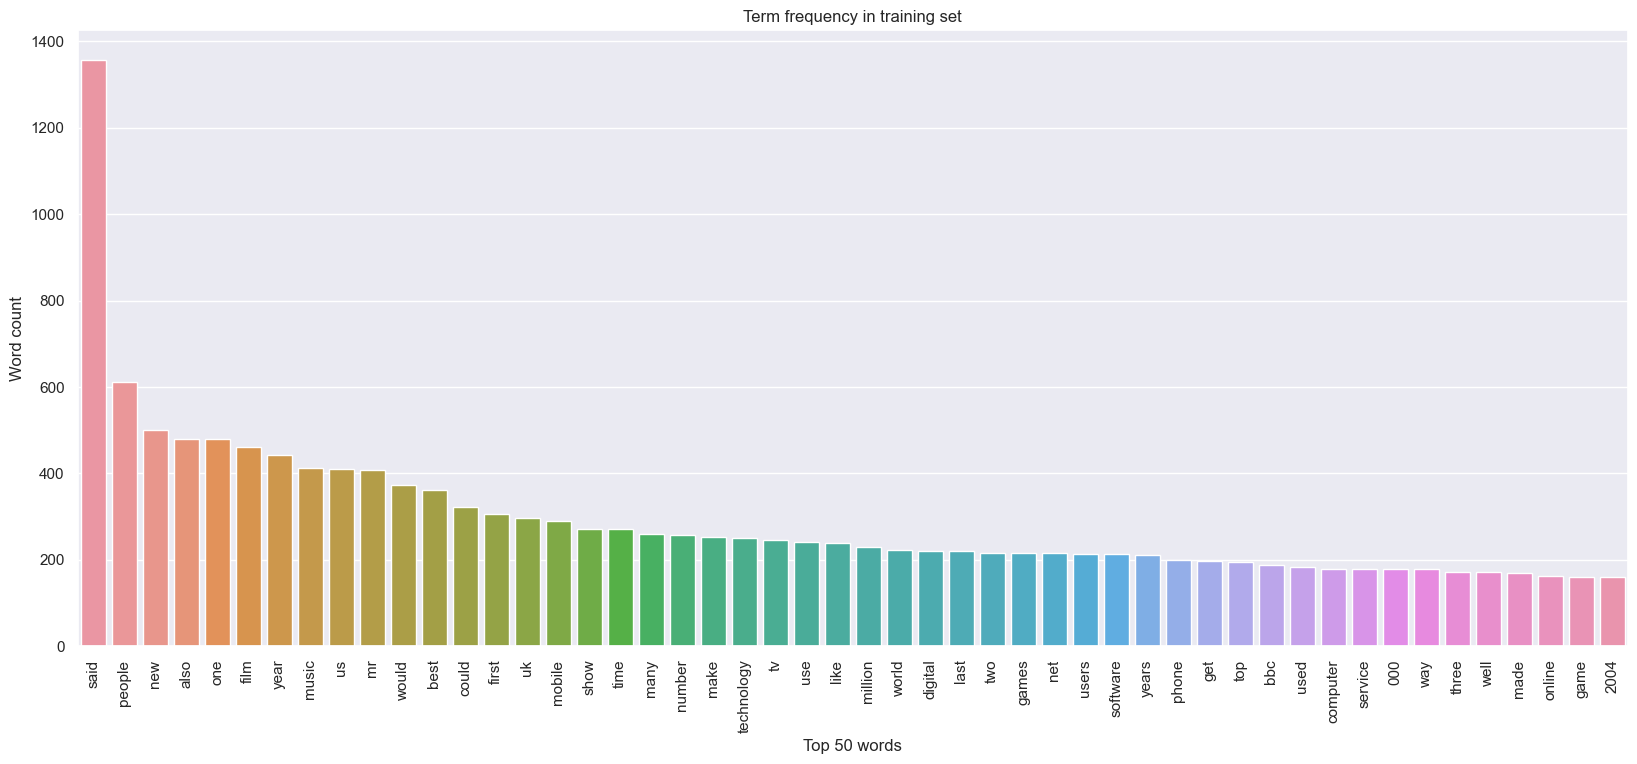

In [75]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

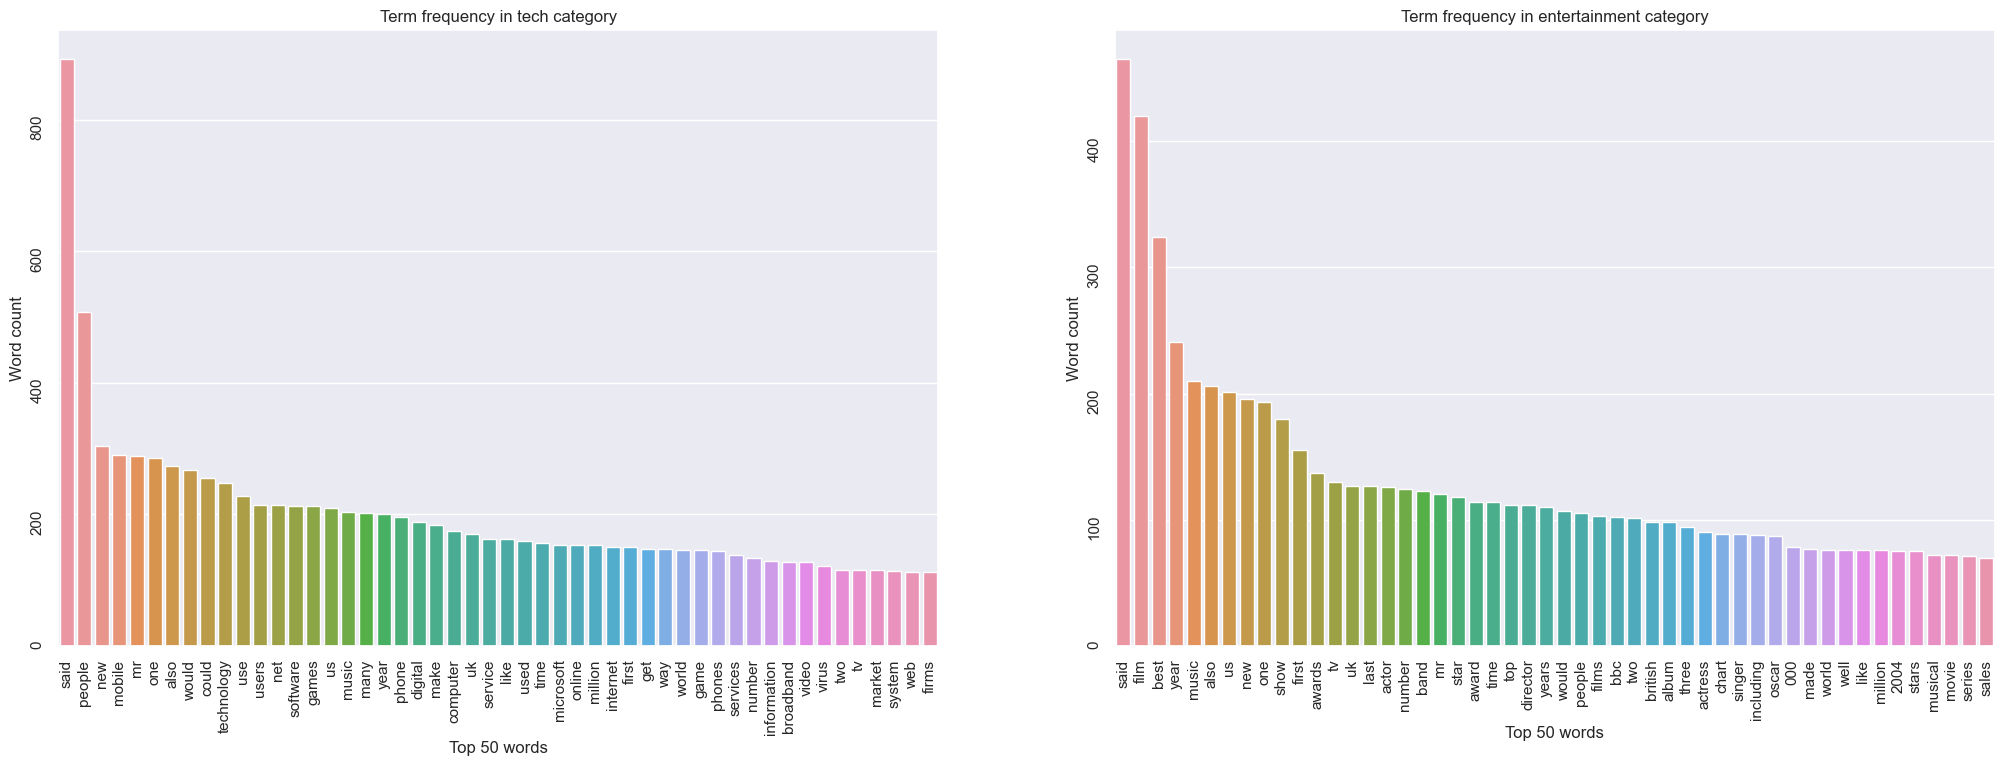

In [76]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

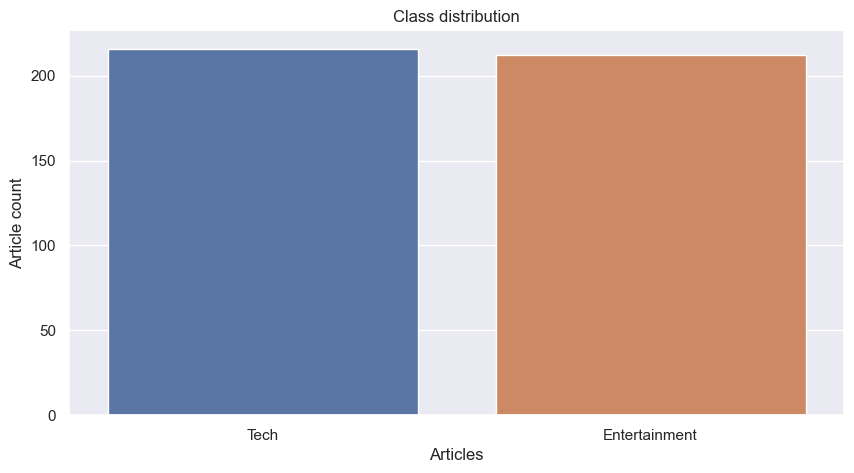

In [77]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [78]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings

#warnings.filterwarnings('ignore')

#np.random.seed(1)

init_weigths = np.random.uniform(0., 0.1, 13518)
hid_units = [5,20,40]
results = []

for hid_unit in hid_units:
    clf = MLPClassifier(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.coefs_ = init_weigths

    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    loss = log_loss(Y_test, preds)
    results.append([hid_unit, loss, score])

print(results)

[[5, 0.3400344659350677, 0.9905660377358491], [20, 0.6800689318701351, 0.9811320754716981], [40, 0.3400344659350677, 0.9905660377358491]]


[]

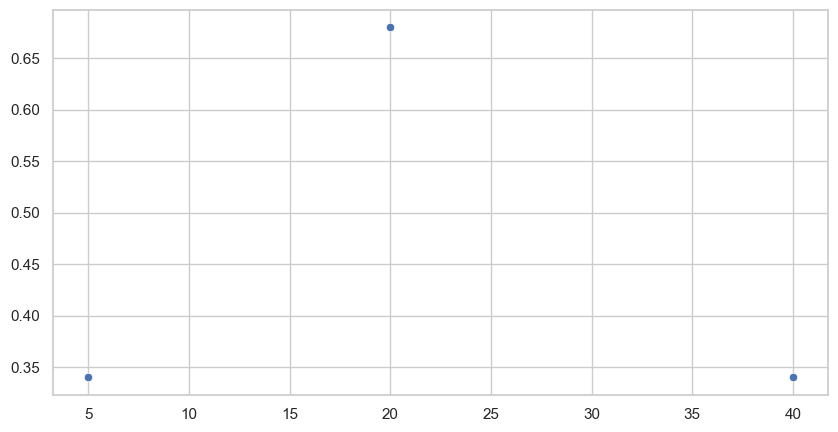

In [80]:
sns.set_style('whitegrid')
results = np.array(results).T
plot = sns.scatterplot(x=results[0], y=results[1])
plt.plot()

# SVM

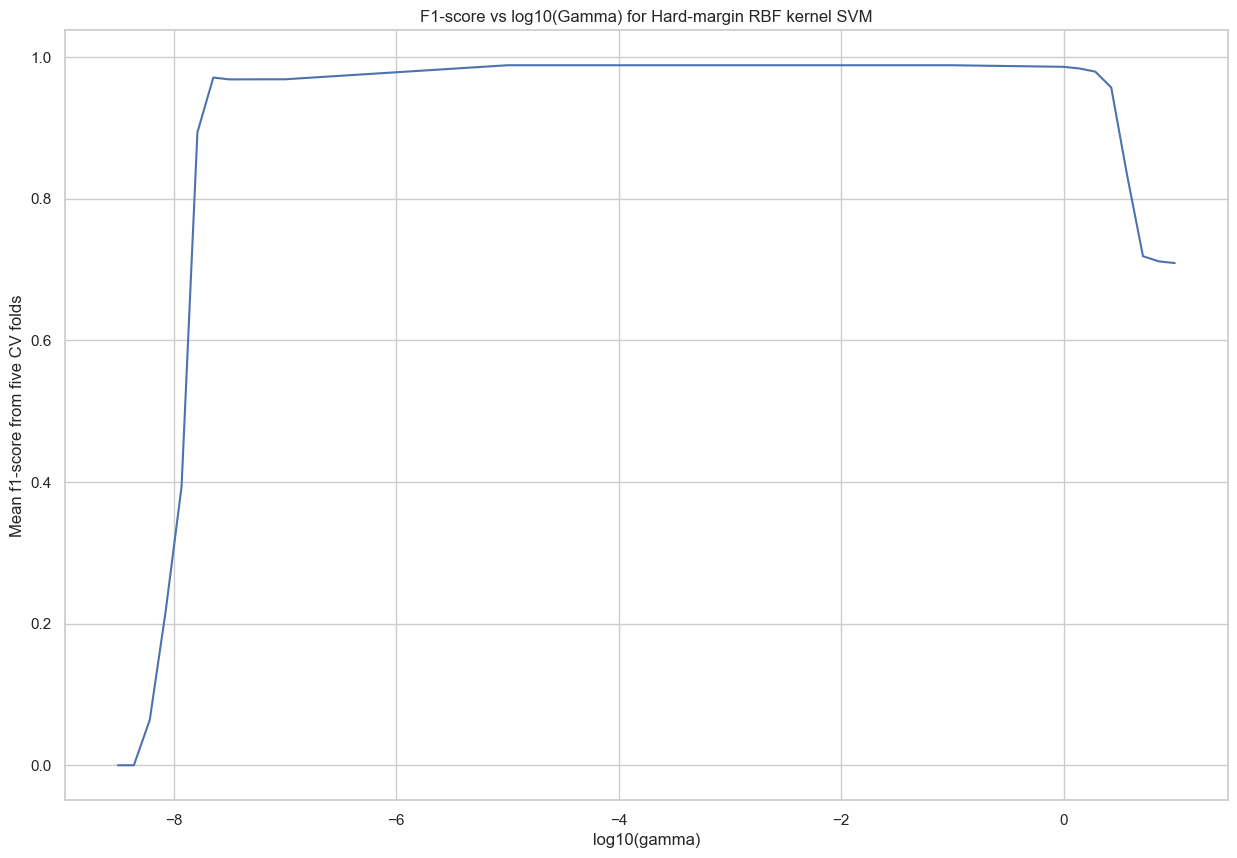

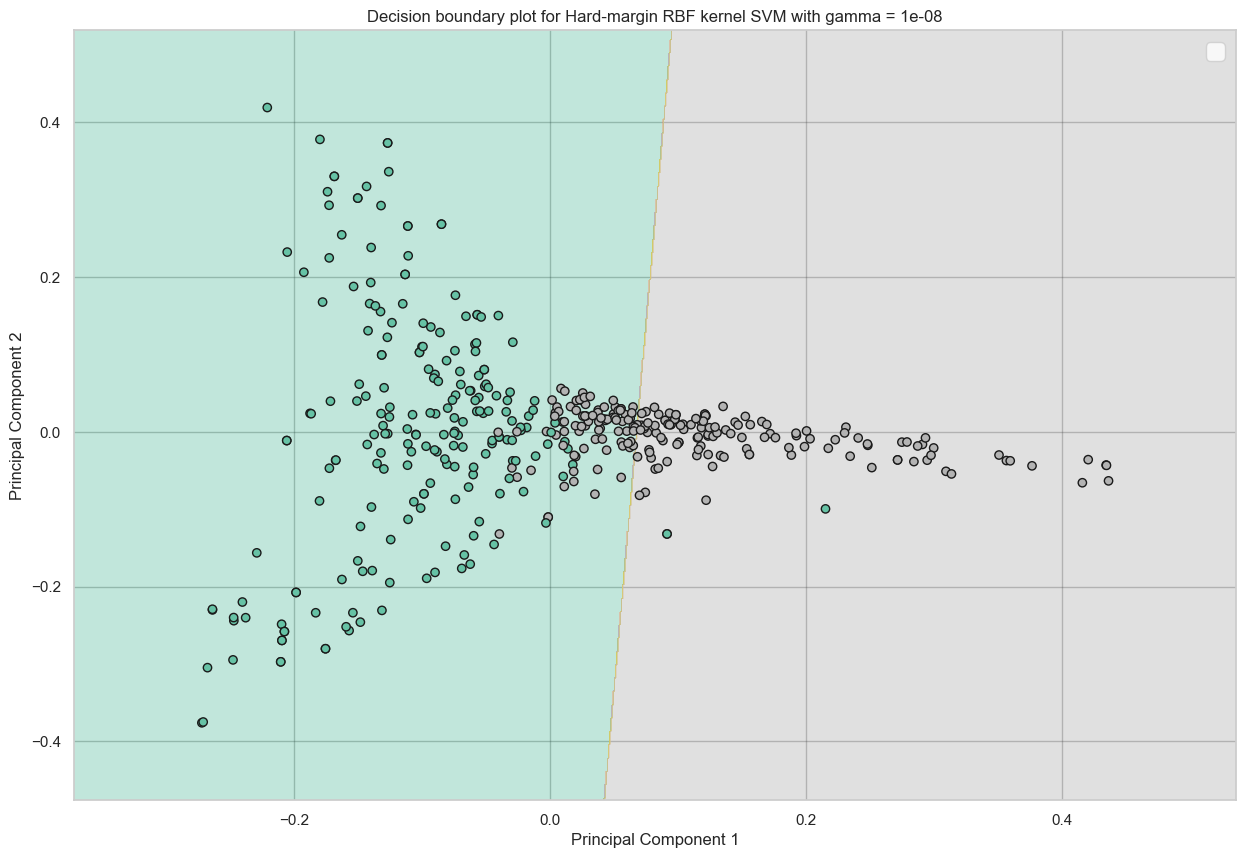

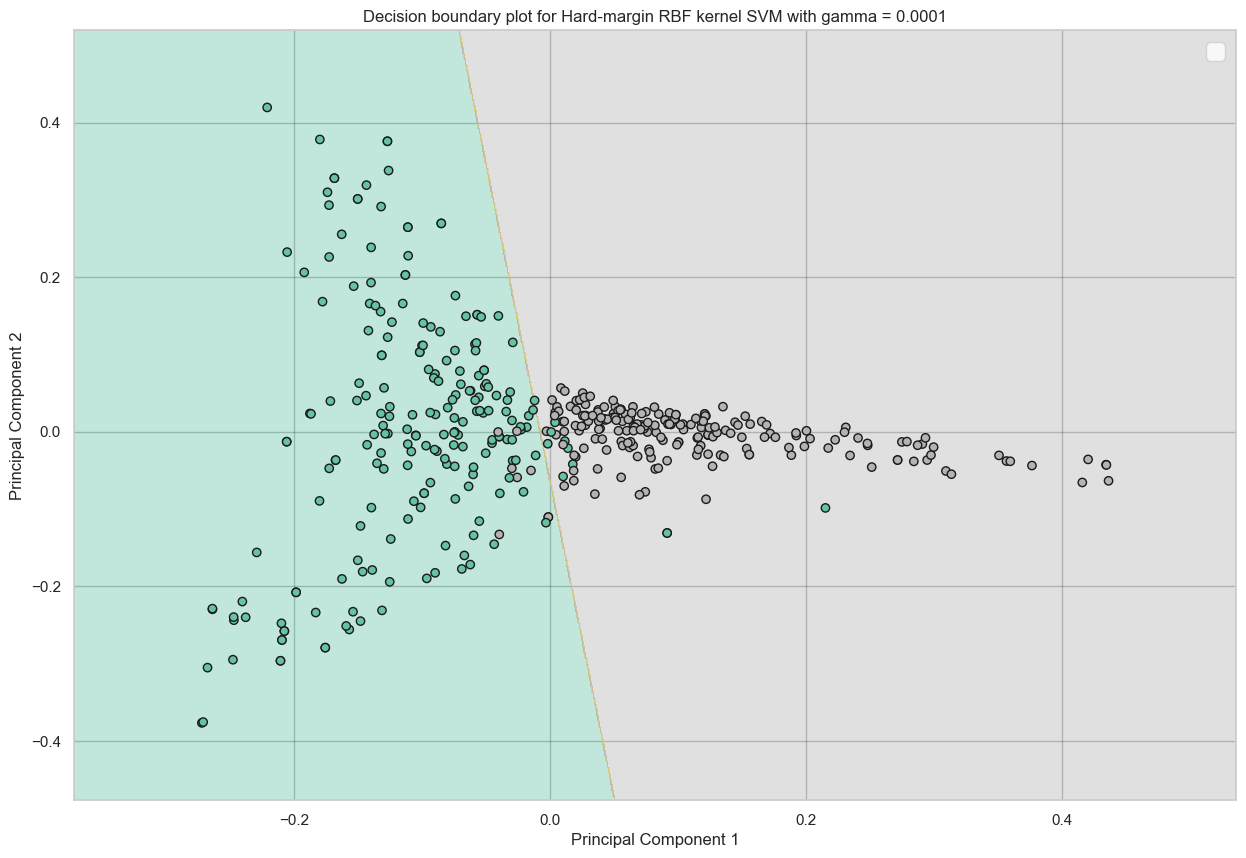

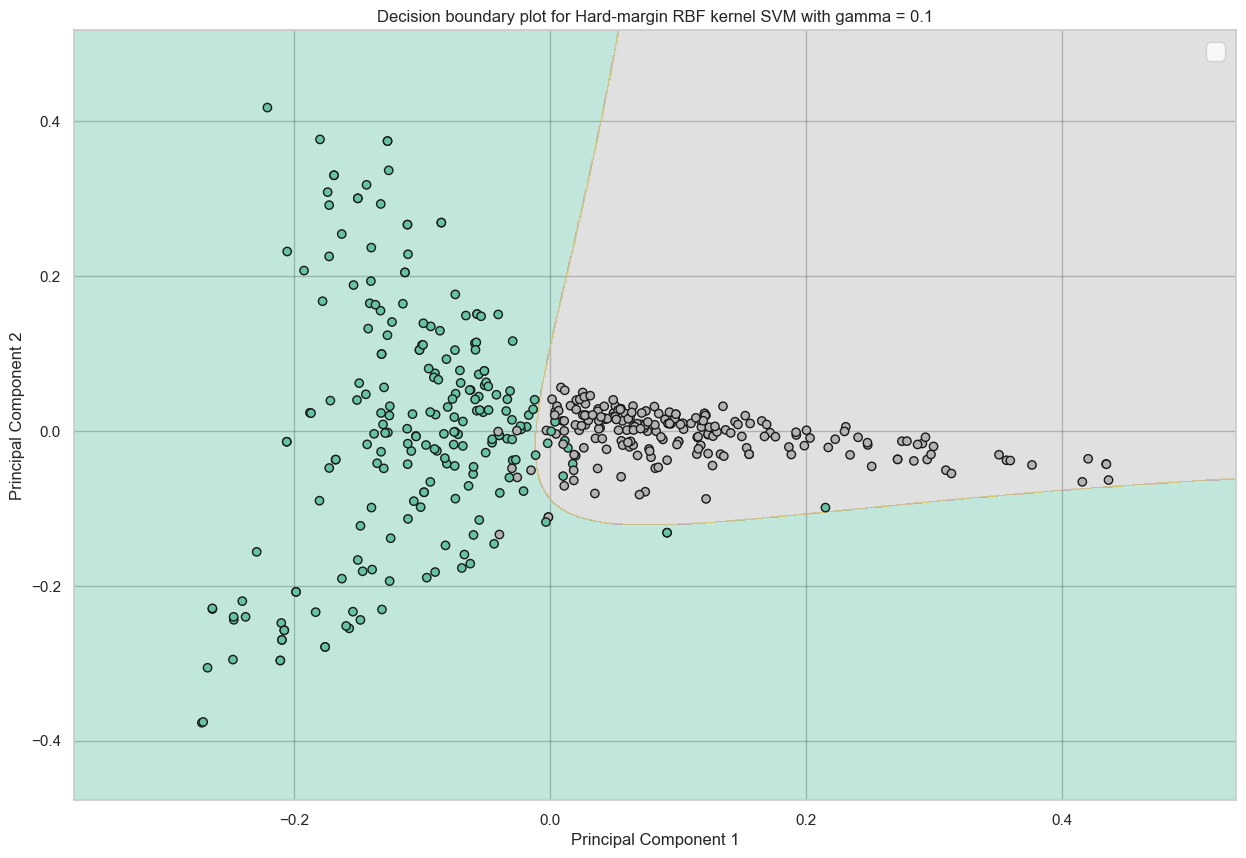

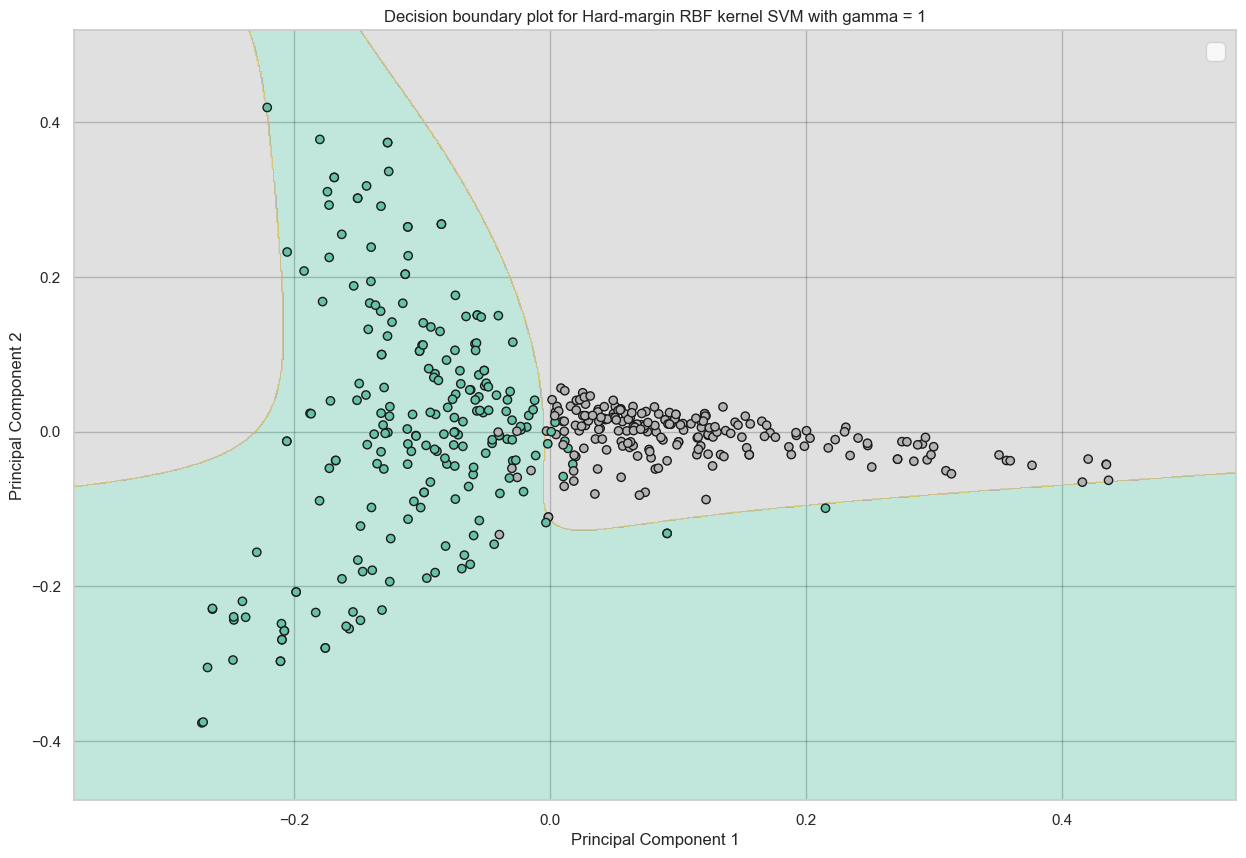

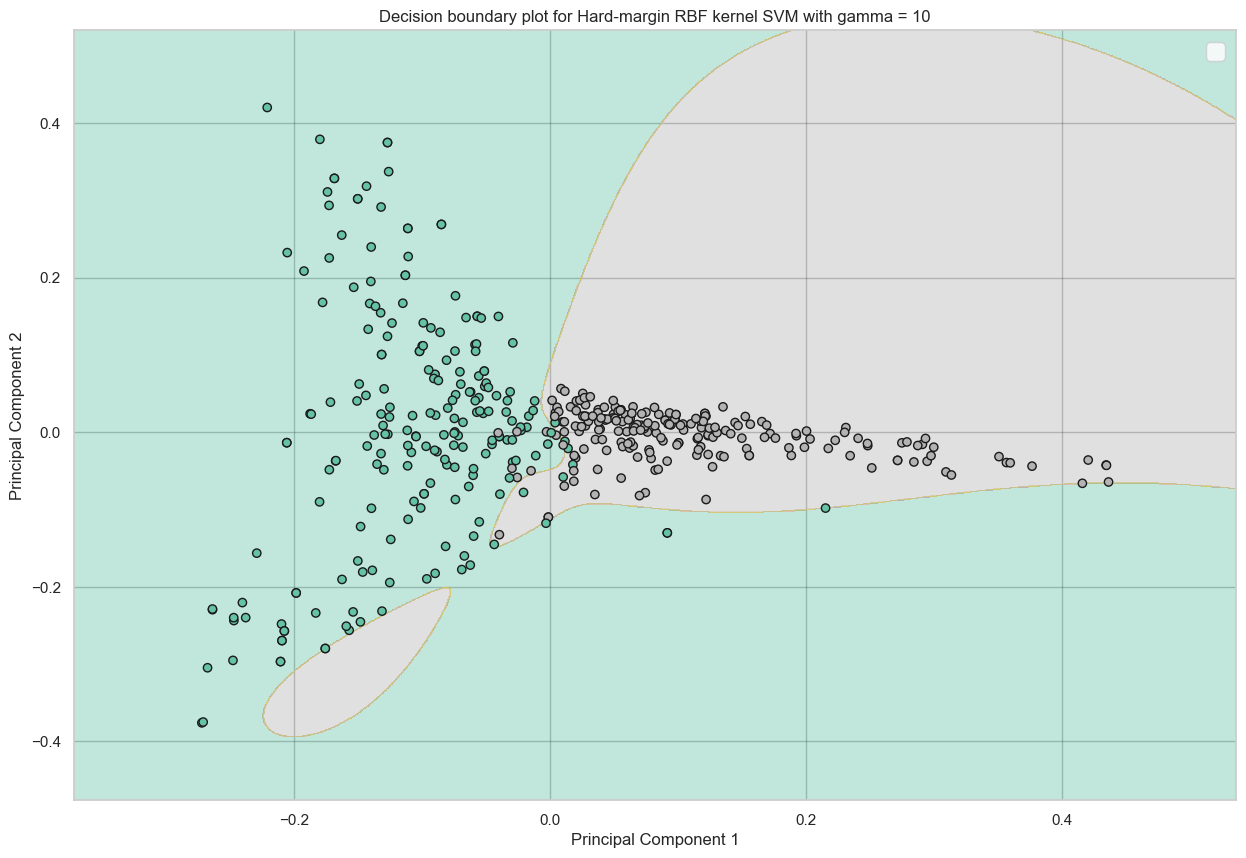

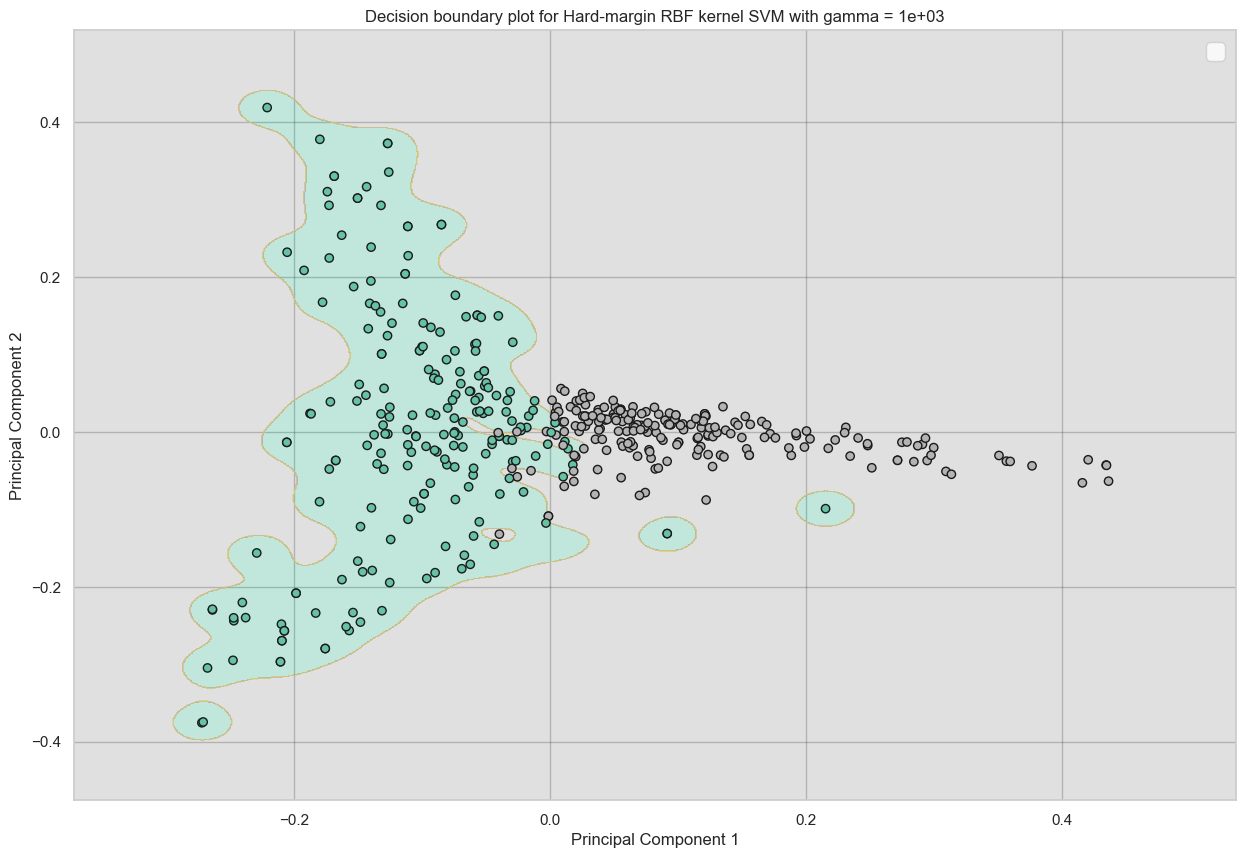

In [254]:
from sklearn import svm


np.random.seed(5)


# CV evaluating effect of gamma on f1-score performance
hyp_arr = np.empty(shape=(20,2))

grange1 = np.logspace(-8.5, -7.5, num = 8)
grange2 = np.logspace(-7, -1, num = 4)
grange3 = np.logspace(0, 1, num = 8)

count = 0

for g in grange1:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
for g in grange2:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1

for g in grange3:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
    
    
# Draw log10(Gamma) vs F1-score plot
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(gamma)"])
hyp_ax = sns.lineplot(hyp_df, x="log10(gamma)", y="Mean f1-score from five CV folds")
hyp_ax.set_title("F1-score vs log10(Gamma) for Hard-margin RBF kernel SVM")






# Apply PCA transform, then train model and draw decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])



gvals = [10 **(-8), 10 ** (-4), 0.1, 1, 10, 1000]


for g in gvals:
    rbf_svc = svm.SVC(kernel='rbf', C=10000000, gamma=g)

    rbf_svc.fit(pca_X_train,Y_train)

    preds = rbf_svc.predict(pca_X_test)
    score = rbf_svc.score(pca_X_test, Y_test)

    
    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.rcParams.update({'font.size': 17})
    
    disp = DecisionBoundaryDisplay.from_estimator(rbf_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    disp.ax_.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    plt.legend(loc="upper right")
    
    disp.ax_.set_title("Decision boundary plot for Hard-margin RBF kernel SVM with gamma = %0.2g" %(g))
        
    plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


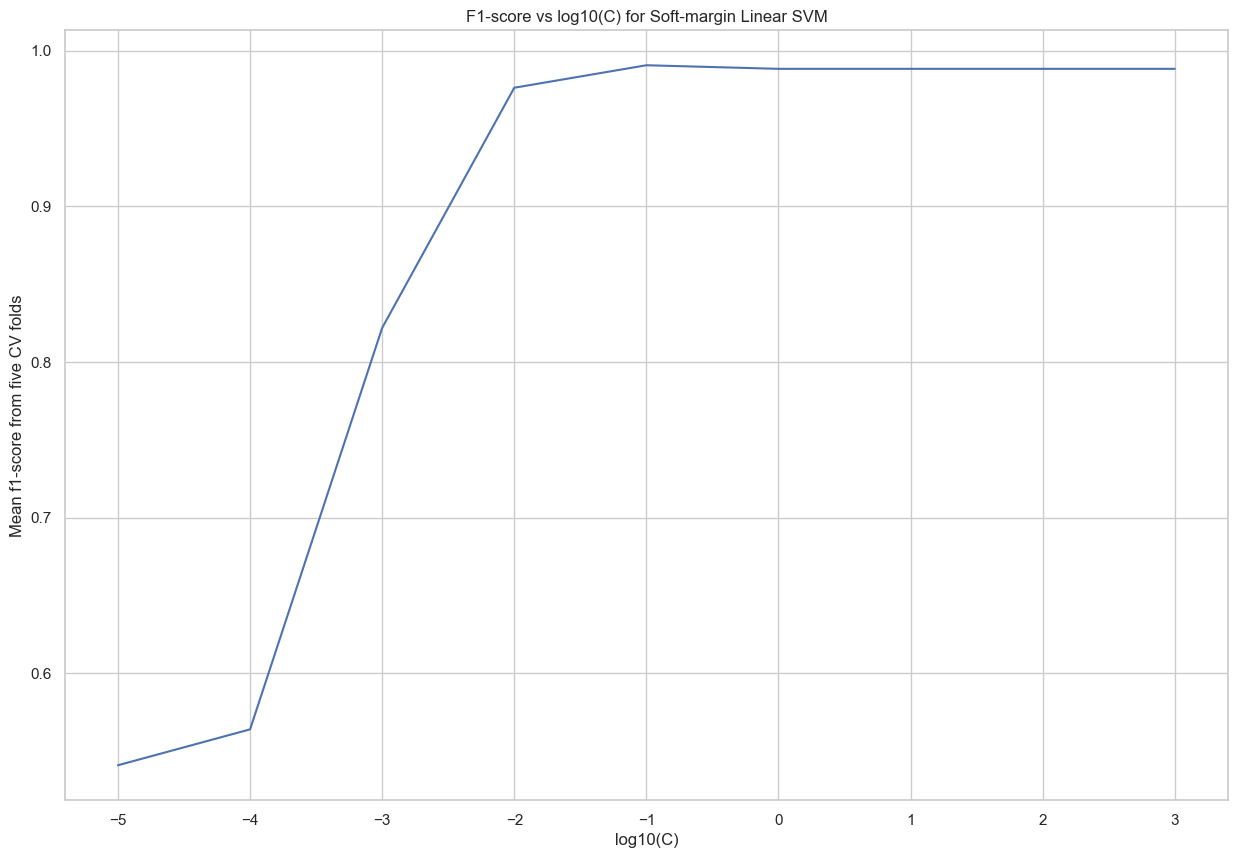

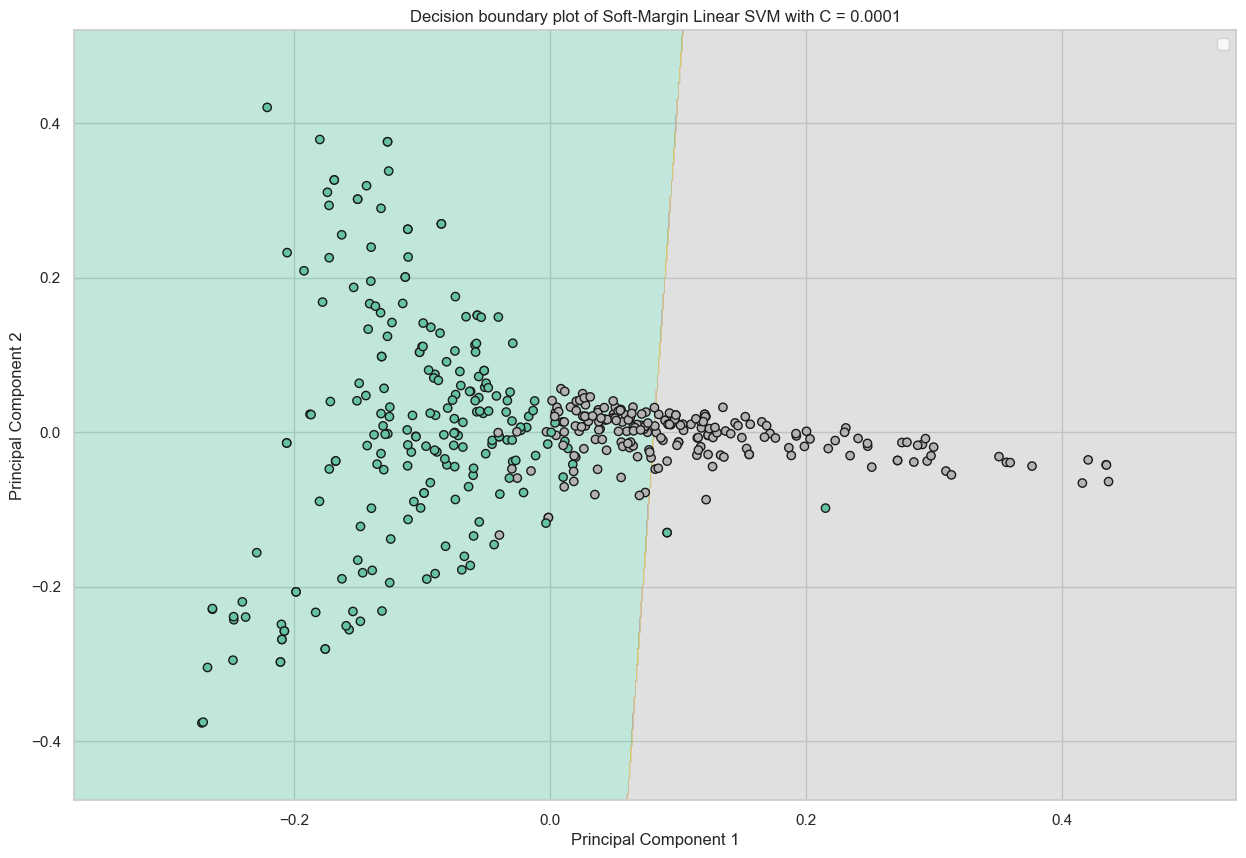

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


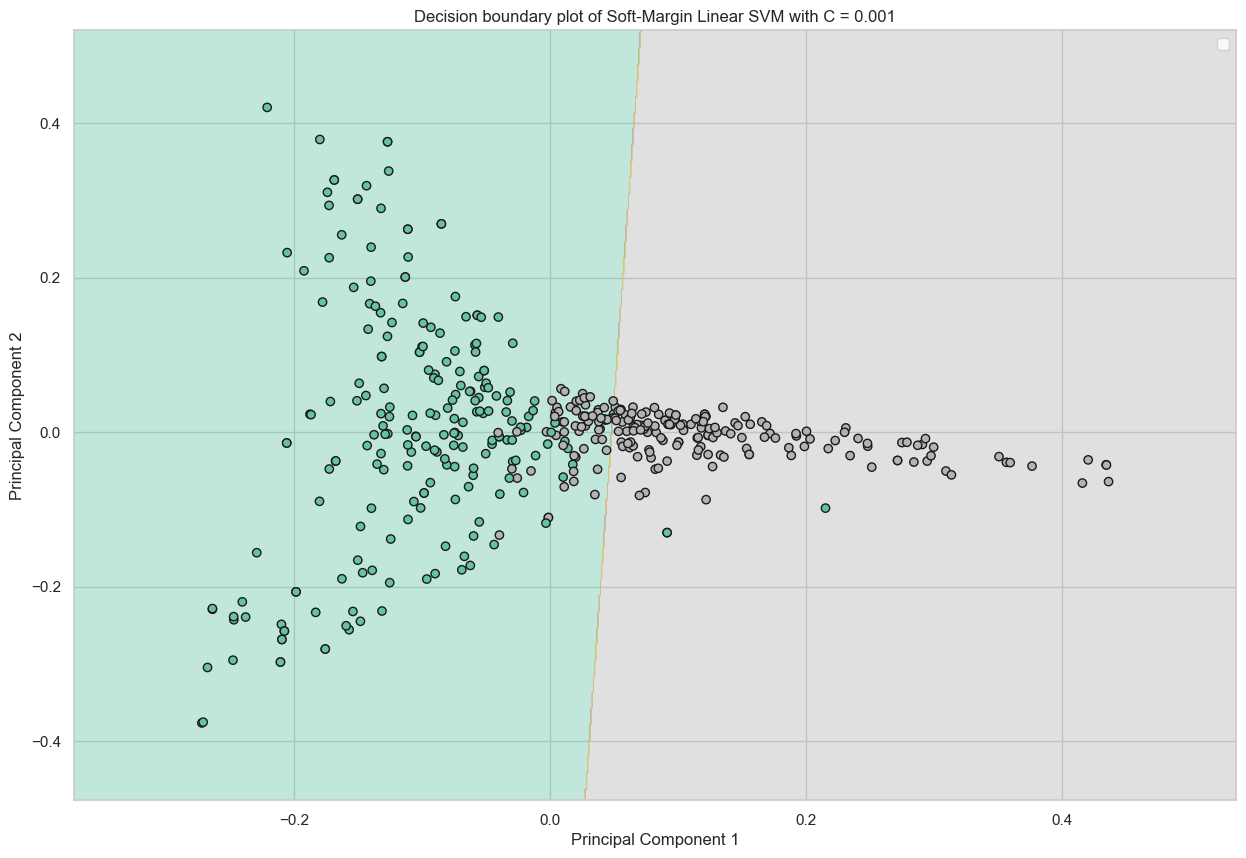

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


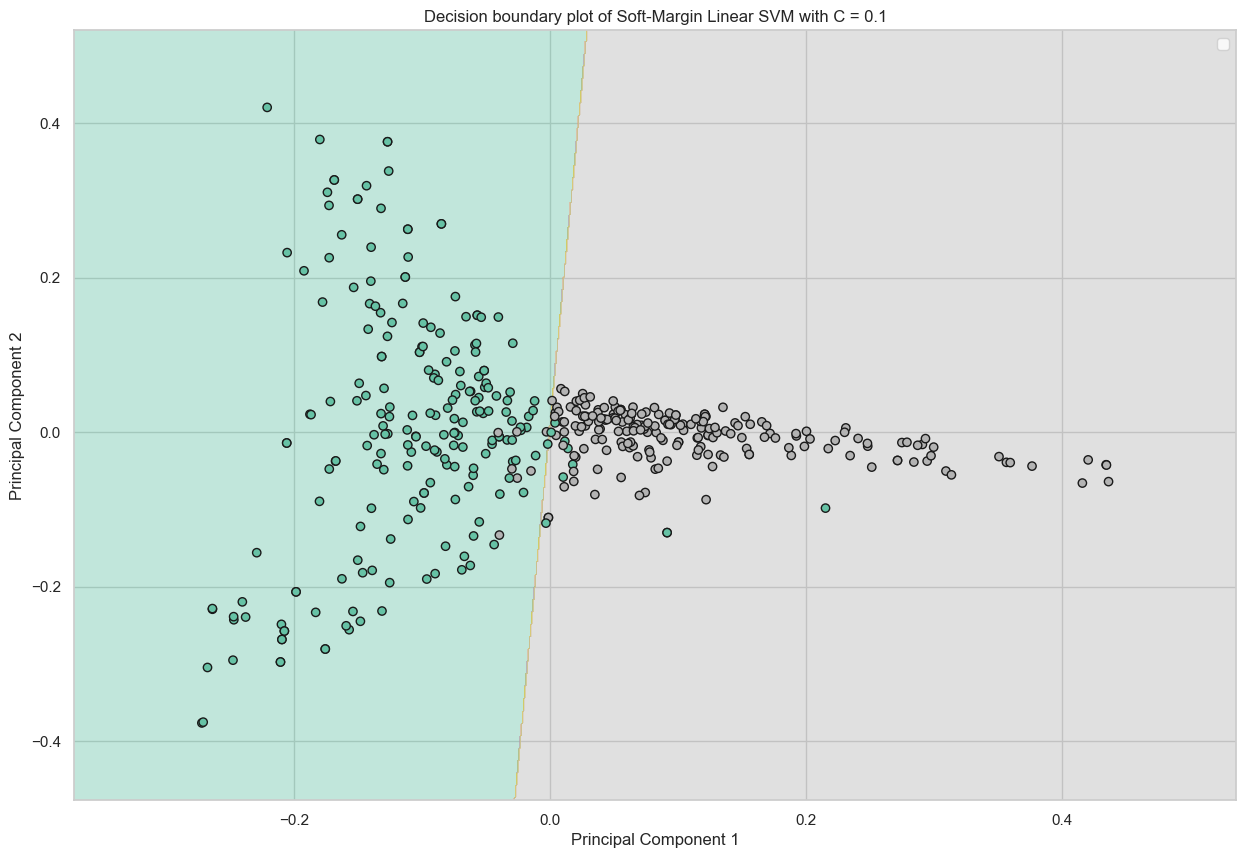

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


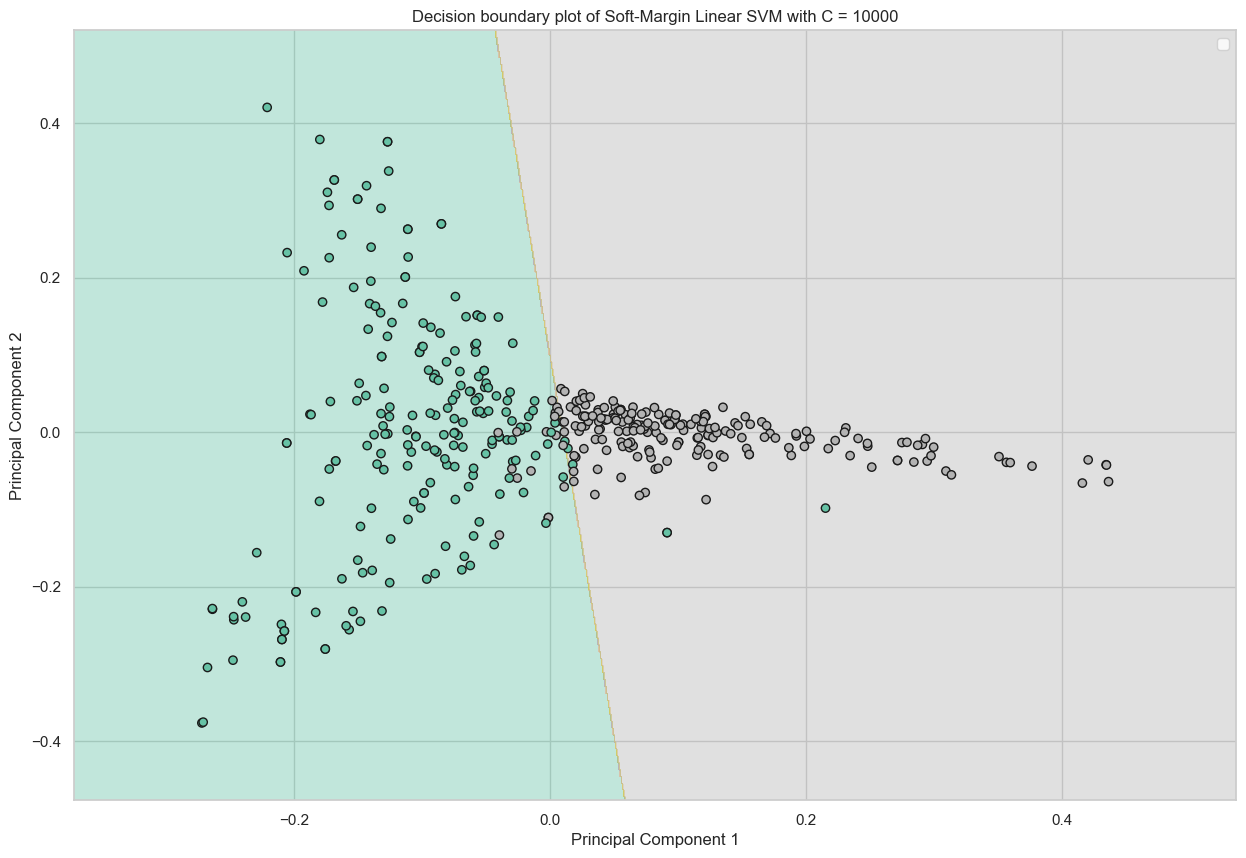

In [260]:
hyp_log = []
scores = []


# CV evaluating effect of C on f1-score performance
hyp_arr = np.empty(shape=(9,2))
crange = np.logspace(-5, 3, num = 9)

count = 0

for c in crange:
    clf = svm.LinearSVC(C=c)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(c))
    count += 1


    

# Draw log10(C) vs F1-score plot
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(C)"])   
hyp_ax = sns.lineplot(hyp_df, x="log10(C)", y="Mean f1-score from five CV folds")
hyp_ax.set_title("F1-score vs log10(C) for Soft-margin Linear SVM")





# Apply PCA transform, then train model and draw decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])


cvals = [10 ** (-4), 10 ** (-3), 10 ** (-1), 10 ** 4]


for c in cvals:
    lin_svc = svm.LinearSVC(C=c)

    lin_svc.fit(pca_X_train,Y_train)

    preds = lin_svc.predict(pca_X_test)
    score = lin_svc.score(pca_X_test, Y_test)



    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams.update({'font.size': 17})
    plt.rcParams['figure.figsize'] = (15, 10)
    
    disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    
    disp.ax_.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    plt.legend(loc="upper right")
    
    if c < 1:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %0.1g" % (c))
    else:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %i" % (c))
        
    plt.show()


Now we find the best kernel and hyperparameters for the SVM. For the measure of performance, we take the mean f1-score across 5 cross validation folds.

We test four kernels: Linear, RBF, Polynomial, and Sigmoid.

All kernels have the soft-margin hyperparameter C.

RBF, Polynomial, and Sigmoid also have a gamma hyperparameter.

Polynomial has an additional hyperparameter, d, which determines the degree of the polynomial.

We use GridSearchCV to find the best combination of hyperparameters for each kernel.

In [272]:
# Using non-PCA data.


cvals = np.logspace(-4, 2, 6)
pgrid = { "C" : cvals }

svc = svm.SVC(kernel="linear")
lin_cv = GridSearchCV(svc, pgrid, scoring="f1")
lin_cv.fit(prep_X_train, Y_train)




gvals = np.logspace(-6, 0, 6)
pgrid["gamma"] = gvals

svc = svm.SVC(kernel="rbf")
rbf_cv = GridSearchCV(svc, pgrid, scoring="f1")
rbf_cv.fit(prep_X_train, Y_train)


svc = svm.SVC(kernel="sigmoid")
sig_cv = GridSearchCV(svc, pgrid, scoring="f1")
sig_cv.fit(prep_X_train, Y_train)




dvals = [2, 3, 4]
pgrid["degree"] = dvals

svc = svm.SVC(kernel="poly")
pol_cv = GridSearchCV(svc, pgrid, scoring="f1")
pol_cv.fit(prep_X_train, Y_train)


GridSearchCV(estimator=SVC(kernel='poly'),
             param_grid={'C': array([1.00000000e-04, 1.58489319e-03, 2.51188643e-02, 3.98107171e-01,
       6.30957344e+00, 1.00000000e+02]),
                         'degree': [2, 3, 4],
                         'gamma': array([1.00000000e-06, 1.58489319e-05, 2.51188643e-04, 3.98107171e-03,
       6.30957344e-02, 1.00000000e+00])},
             scoring='f1')

In [292]:

lin_cv.cv_results_
print("Test set f1-score of Linear SVM is %0.4f. C = %0.4f." %
      (lin_cv.score(prep_X_test, Y_test), lin_cv.best_params_["C"]))


rbf_cv.cv_results_
print("Test set f1-score of RBF SVM is %0.4f. C = %0.4f, gamma = %0.4f" %
      (rbf_cv.score(prep_X_test, Y_test), rbf_cv.best_params_["C"], rbf_cv.best_params_["gamma"]))


sig_cv.cv_results_
print("Test set f1-score of Sigmoid SVM is %0.4f. C = %0.4f, gamma = %0.4f" %
      (sig_cv.score(prep_X_test, Y_test), sig_cv.best_params_["C"], sig_cv.best_params_["gamma"]))


pol_cv.cv_results_
print("Test set f1-score of Sigmoid SVM is %0.4f. C = %0.4f, degree = %i, gamma = %0.4f" %
      (pol_cv.score(prep_X_test, Y_test), pol_cv.best_params_["C"], pol_cv.best_params_["degree"],
       pol_cv.best_params_["gamma"]))



from sklearn.metrics import f1_score



percents = [0.1, 0.3, 0.5, 0.7, 0.9]
acc_arr = np.empty(shape=(len(percents),2))

for i in range(len(percents)):
    m = percents[i]
    n = math.ceil(len(prep_X_train.index) * m)
    print(n)
    
    clf = svm.SVC(kernel="sigmoid", C=sig_cv.best_params_["C"], gamma=sig_cv.best_params_["gamma"])
    clf.fit(prep_X_train.iloc[0: n], Y_train.iloc[0: n])
    
    train_preds = clf.predict(prep_X_train.iloc[0: n])
    test_preds = clf.predict(prep_X_test)
    
    train_f1 = f1_score(Y_train.iloc[0: n], train_preds)
    test_f1 = f1_score(Y_test, test_preds)
    
    acc_arr[i] = (train_f1, test_f1)

print(acc_arr)
    
    


Test set f1-score of Linear SVM is 1.0000. C = 0.3981.
Test set f1-score of RBF SVM is 0.9917. C = 6.3096, gamma = 0.0631
Test set f1-score of Sigmoid SVM is 1.0000. C = 6.3096, gamma = 0.0631
Test set f1-score of Sigmoid SVM is 0.9919. C = 0.3981, degree = 2, gamma = 1.0000
43
129
214
300
386
[[0.         0.        ]
 [0.9924812  0.976     ]
 [0.99521531 0.99186992]
 [0.99653979 0.99173554]
 [0.9974026  1.        ]]
